In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
import os
from operator import itemgetter
import warnings

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from allen_v1dd.client import EMClient
from allen_v1dd import plotting
from allen_v1dd.em import DynamicSynapseGraph

import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

# Load the EM client

In [3]:
em_client = EMClient.init_microns(datastack_name="minnie65_phase3_v1")
cell_type_table = "aibs_soma_nuc_metamodel_preds_v117"
proofreading_table = "proofreading_status_public_release"

# Load soma positions and cell types

In [4]:
cell_type_df = em_client.query_table(cell_type_table)
cell_type_df["pt_position_microns"] = em_client.transform_position_to_microns(cell_type_df["pt_position"])
cell_type_df.head()

,id_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,valid,target_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position,pt_position_microns
0,498173,t,308.176159,103884538719281829,864691135373830344,553,t,498173,aibs_neuronal,6P-IT,"[1138752.0, 847744.0, 622640.0]","[nan, nan, nan]","[nan, nan, nan]","[1060.532946861501, 547.0958222941854, 622.640..."
1,487329,t,295.937638,105279407463397326,864691135975935434,4509,t,487329,aibs_neuronal,MC,"[1178176.0, 474496.0, 869800.0]","[nan, nan, nan]","[nan, nan, nan]","[1132.3376333081478, 178.7041716229213, 869.80..."
2,106662,t,230.148178,79524515478544304,864691136084076652,4693,t,106662,aibs_neuronal,23P,"[428224.0, 476992.0, 776560.0]","[nan, nan, nan]","[nan, nan, nan]","[385.0218863509487, 115.82805000426656, 776.56..."
3,271350,t,305.328128,87351114324194368,864691135777995965,5061,t,271350,aibs_neuronal,6P-CT,"[655680.0, 943872.0, 835000.0]","[nan, nan, nan]","[nan, nan, nan]","[570.9210744260782, 600.755527271752, 835.0000..."
4,456040,t,257.463910,101129507251445952,864691136084057196,8652,t,456040,aibs_neuronal,MC,"[1058176.0, 530112.0, 959520.0]","[nan, nan, nan]","[nan, nan, nan]","[1007.9470157484845, 223.64984682227282, 959.5..."


In [5]:
root_id_to_cell_type = pd.Series(index=cell_type_df.pt_root_id.values, data=cell_type_df.cell_type.values)
root_id_to_soma_pos = pd.Series(index=cell_type_df.pt_root_id.values, data=cell_type_df.pt_position_microns.values)

In [8]:
cell_type_df.cell_type.value_counts()

23P          19139
4P           13407
6P-IT        10746
5P-IT         9060
astrocyte     7724
6P-CT         5862
oligo         4998
BC            3084
microglia     3024
OPC           2483
MC            2270
5P-ET         1626
BPC           1424
pericyte       962
NGC            651
5P-NP          456
Name: cell_type, dtype: int64

In [11]:
# Which fraction of cells (incl. non-neuronal) are excitatory?
val_cts = cell_type_df.cell_type.value_counts()
n_exc = cell_type_df.cell_type.isin(em_client.exc_cell_types).sum()
n_tot = len(cell_type_df)
n_exc, n_tot, n_exc/n_tot

(60296, 86916, 0.6937272769110405)

In [30]:
col_type_df = em_client.query_table("allen_v1_column_types_slanted_ref")
central_col_root_ids = col_type_df.pt_root_id.values

# Identify which cells have been proofread

In [32]:
proof_df = em_client.query_table(proofreading_table)
axon_proof = pd.Series(index=proof_df.pt_root_id.values, data=proof_df.status_axon.values)
dendrite_proof = pd.Series(index=proof_df.pt_root_id.values, data=proof_df.status_dendrite.values)

proof_df.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,1,t,105913344770753749,864691134884807418,864691134884807418,extended,extended,"[1196268.0, 492516.0, 919720.0]"
1,2,t,89671564962230422,864691134885430010,864691134885430010,extended,non,"[725120.0, 892160.0, 855960.0]"
2,3,t,88475227658538846,864691134885645050,864691134885645050,extended,non,"[689152.0, 890112.0, 864280.0]"
3,4,t,88194302236603527,864691134918370314,864691134918370314,clean,clean,"[682112.0, 907392.0, 812640.0]"
4,5,t,90854983003652860,864691134918461194,864691134918461194,clean,clean,"[759040.0, 510080.0, 821600.0]"


In [33]:
proof_axon_ids = proof_df.pt_root_id.values[proof_df.status_axon.isin(["extended"])]
proof_dendrite_ids = proof_df.pt_root_id.values[proof_df.status_dendrite.isin(["clean", "extended"])]
print(len(proof_axon_ids), "proofread axons")
print(len(proof_dendrite_ids), "proofread dendrites")

325 proofread axons
1260 proofread dendrites


# Plot soma positions

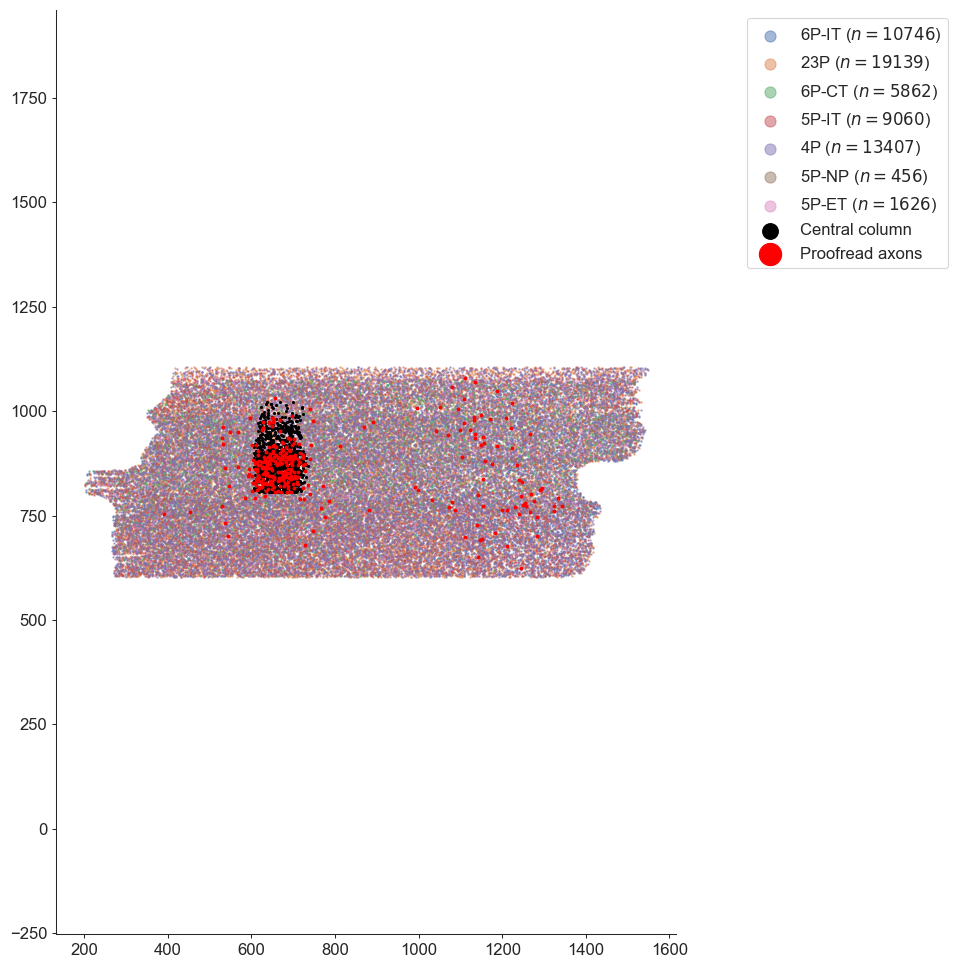

In [114]:
fig, ax = plt.subplots(figsize=(8, 12))
x_coord, y_coord = 0, 2

for cell_type in cell_type_df.cell_type.unique():
    if cell_type not in em_client.exc_cell_types: continue
    pos = cell_type_df.pt_position_microns[cell_type_df.cell_type == cell_type]
    x = pos.apply(itemgetter(x_coord))
    y = pos.apply(itemgetter(y_coord))
    ax.scatter(x, y, label=f"{cell_type} ($n = {len(pos)}$)", s=1, alpha=0.5)

pos = cell_type_df.pt_position_microns[cell_type_df.pt_root_id.isin(central_col_root_ids)]
x = pos.apply(itemgetter(x_coord))
y = pos.apply(itemgetter(y_coord))
ax.scatter(x, y, label=f"Central column", s=2, color="black")

mask_a = cell_type_df.pt_root_id.isin(proof_axon_ids)
mask_d = cell_type_df.pt_root_id.isin(proof_dendrite_ids)

pos = cell_type_df.pt_position_microns[mask_a]
x = pos.apply(itemgetter(x_coord))
y = pos.apply(itemgetter(y_coord))
ax.scatter(x, y, label=f"Proofread axons", s=4, color="red")

# pos = cell_type_df.pt_position_microns[mask_a & ~mask_d]
# x = pos.apply(itemgetter(0))
# y = pos.apply(itemgetter(1))
# ax.scatter(x, y, label=f"Proofread axons", s=2, color="red")

# pos = cell_type_df.pt_position_microns[mask_d & ~mask_a]
# x = pos.apply(itemgetter(0))
# y = pos.apply(itemgetter(1))
# ax.scatter(x, y, label=f"Proofread dendrites", s=2, color="blue")

# pos = cell_type_df.pt_position_microns[mask_a & mask_d]
# x = pos.apply(itemgetter(0))
# y = pos.apply(itemgetter(1))
# ax.scatter(x, y, label=f"Proofread axons and dendrites", s=5, color="green")

ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1), bbox_transform=ax.transAxes, markerscale=8)

if y_coord == 1:
    ax.invert_yaxis()
elif x_coord == 0 and y_coord == 2:
    ax.axis("equal")
# add_layer_lines(ax)

# Load the synapse graph

In [104]:
syn_graph_dir = "/Users/chase/Desktop"
syn_graph_filename = f"{em_client.cave_client.datastack_name}_v{em_client.version}_synapses.gpl"
syn_graph = DynamicSynapseGraph(em_client, debug=True, filename=os.path.join(syn_graph_dir, syn_graph_filename))

Loading graph from file /Users/chase/Desktop/minnie65_phase3_v1_v660_synapses.gpl


### Some helper tools for plotting

In [97]:
def matches_or_in(series, val):
    if type(val) is str:
        return series == val
    else:
        return series.isin(val)

def get_cell_type_str(cell_type):
    if cell_type == em_client.exc_cell_types:
        return "E"
    elif cell_type == em_client.inh_cell_types:
        return "I"
    elif type(cell_type) is not str:
        return str(cell_type)
    else:
        return cell_type

def is_in_layer(pos, layer, boundary_padding=0):
    min_depth, max_depth = em_client.layer_boundaries[layer]
    min_depth -= boundary_padding
    max_depth += boundary_padding

    if isinstance(pos, pd.Series):
        return pos.apply(lambda p: min_depth <= p[1] <= max_depth)
    elif isinstance(pos, np.ndarray) and len(pos.shape) == 2:
        return (min_depth <= pos[:,1]) & (pos[:,1] <= max_depth)
    else:
        return min_depth <= pos[1] <= max_depth

In [139]:
num_edits_df = pd.read_csv("/Users/chase/Desktop/num_edits_df_03312023.csv")
num_edits_df.head()

,root_id,num_changes
0,864691134606726885,0
1,864691134843987622,0
2,864691134917644042,1
3,864691135034407702,0
4,864691135194387242,1


In [143]:
high_edits_root_ids = num_edits_df.root_id.values[num_edits_df.num_changes >= 100]
print(f"{len(high_edits_root_ids)} cells with a large number of edits")

993 cells with a large number of edits


# Plot parameters

In [152]:
cell_types_no_layer = [
    ("MC", plotting.MC_COLOR),
    ("BC", plotting.BC_COLOR),
    ("BPC", plotting.BPC_COLOR),
    (em_client.exc_cell_types, plotting.EXC_COLOR),
]
layers = ["2/3", "4", "5", "6"]
# layers = ["5", "6"]
# layers = ["4", "5"]

# All combinations of cell types and layers
cell_types = []
for layer in layers:
    for c in cell_types_no_layer:
        cell_types.append((*c, layer))

dist_range = np.arange(10, 1000)
dist_window_radius = 1 # microns
dist_metric = "soma_soma_dist_horiz"
# dist_metric = "soma_soma_dist"
fit_gaussian = False
max_num_cells = 100 # max number of presynaptic cells to include (None if all)

In [153]:
# Count number of cells that match
for cell_type, color, layer in cell_types:
    mask = (
        matches_or_in(cell_type_df.cell_type, cell_type) # is cell type
        & is_in_layer(cell_type_df.pt_position_microns, layer) # is in layer
        & (cell_type_df.pt_root_id.isin(proof_axon_ids) | cell_type_df.pt_root_id.isin(high_edits_root_ids)) # has proofread axon OR sufficiently many edits
        & cell_type_df.pt_root_id.isin(central_col_root_ids) # in central column
    )
    print(f"L{layer} {get_cell_type_str(cell_type)}: {mask.sum()}")

L2/3 MC: 7
L2/3 BC: 12
L2/3 BPC: 12
L2/3 E: 343
L4 MC: 9
L4 BC: 13
L4 BPC: 11
L4 E: 244
L5 MC: 17
L5 BC: 22
L5 BPC: 4
L5 E: 75
L6 MC: 12
L6 BC: 11
L6 BPC: 5
L6 E: 21


In [154]:
fig, axs = plt.subplots(figsize=(5*len(cell_types), 3.5*len(cell_types)), nrows=len(cell_types), ncols=len(cell_types))

for row_i, (pre_cell_type, pre_color, pre_layer) in enumerate(cell_types):
    # Identify the population of PRESYNAPTIC cells
    pre_population_df = cell_type_df[
        matches_or_in(cell_type_df.cell_type, pre_cell_type) # is cell type
        & is_in_layer(cell_type_df.pt_position_microns, pre_layer) # is in layer
        # & cell_type_df.pt_root_id.isin(proof_axon_ids) # has proofread axon
        & (cell_type_df.pt_root_id.isin(proof_axon_ids) | cell_type_df.pt_root_id.isin(high_edits_root_ids)) # has proofread axon OR sufficiently many edits
        & cell_type_df.pt_root_id.isin(central_col_root_ids) # in central column
    ]
    pre_root_ids = pre_population_df.pt_root_id.values
    pre_soma_pos = np.vstack(pre_population_df.pt_position_microns.values)

    # Trim to the max amount if too many over
    n_pre = len(pre_root_ids)
    if max_num_cells is not None and len(pre_root_ids) > max_num_cells:
        pre_root_ids = pre_root_ids[:max_num_cells]
    print(f"# L{pre_layer} {get_cell_type_str(pre_cell_type)} = {len(pre_root_ids)}/{n_pre}")
    n_pre = len(pre_root_ids)

    # Load the axonal synapses for these cells
    all_axo_syn = syn_graph.get_axonal_synapses(pre_root_ids)

    # If there are multiple synapses between two cells, sum the synapse sizes
    all_axo_syn = all_axo_syn.groupby(["pre_pt_root_id", "post_pt_root_id"]).aggregate(dict(
        size="sum",
        soma_soma_dist="first", # these are the same for every (pre, post) pair, so just keep the first
        soma_soma_dist_horiz="first"
    )).reset_index()

    for col_i, (post_cell_type, post_color, post_layer) in enumerate(cell_types):
        ax = axs[row_i, col_i]

        # Identify the population of POSTSYNAPTIC cells
        post_population_df = cell_type_df[
            matches_or_in(cell_type_df.cell_type, post_cell_type) # is cell type
            & is_in_layer(cell_type_df.pt_position_microns, post_layer) # is in layer
            # & cell_type_df.pt_root_id.isin(proof_dendrite_ids) # ignoring dendritic proofreading
        ]
        post_population_root_ids = post_population_df.pt_root_id.values
        post_population_soma_pos = np.vstack(post_population_df.pt_position_microns.values)

        # Identify relevant synapses between pre- and postsynaptic groups
        syn_between_groups = all_axo_syn[all_axo_syn.post_pt_root_id.isin(post_population_root_ids)]
        
        # Compute the synapse size at each distance
        syn_size_at_dist = np.full_like(dist_range, np.nan, dtype=float)

        for dist_i, dist in enumerate(dist_range):
            syn_at_dist = syn_between_groups[np.abs(syn_between_groups[dist_metric] - dist) < dist_window_radius]
            n_pre_post_pairs = len(syn_at_dist) # number of unique (pre, post) pairs
            if n_pre_post_pairs == 0: continue # ignore if no synapses
            total_size_at_dist = syn_at_dist["size"].sum()
            syn_size_at_dist[dist_i] = total_size_at_dist / n_pre_post_pairs

        # Compute rolling average
        rolling_avg_r = 5
        y_rolling_avg = np.full_like(dist_range, np.nan, dtype=float)
        kernel = np.ones(2*rolling_avg_r+1) / (2*rolling_avg_r+1) # Rolling average kernel
        # kernel = scipy.ndimage.gaussian_filter1d(np.array([0]*rolling_avg_r + [1] + [0]*rolling_avg_r, dtype=float), sigma=3) # Gaussian kernel

        for dist_i in range(rolling_avg_r, len(dist_range) - rolling_avg_r):
            rolling_avg_slice = slice(dist_i-rolling_avg_r, dist_i+rolling_avg_r+1)
            y_rolling_avg[dist_i] = np.nansum(syn_size_at_dist[rolling_avg_slice] * kernel)

        # Scatter all points
        ax.scatter(dist_range, syn_size_at_dist, color="black", s=25, alpha=0.25)

        # Plot rolling average
        ax.plot(dist_range, y_rolling_avg, color="black", linewidth=3, linestyle="solid")

        # Plot the pre and post populations
        ax_inset = ax.inset_axes([0.6, 0.6, 0.3, 0.3])
        pre_inset_color = "black" if pre_color == post_color and pre_layer == post_layer else pre_color
        ax_inset.scatter(pre_soma_pos[:,0], pre_soma_pos[:,1], color=pre_inset_color)
        ax_inset.scatter(post_population_soma_pos[:,0], post_population_soma_pos[:,1], color=post_color, s=0.5, alpha=0.25, zorder=0, label=f"{post_cell_type}")
        ax_inset.invert_yaxis()
        (xmin, xmax), (ymin, ymax) = ax_inset.get_xlim(), ax_inset.get_ylim()
        ax_inset.vlines(x=xmin, ymin=ymin, ymax=ymin-100, color="black")
        ax_inset.hlines(y=ymin, xmin=xmin, xmax=xmin+100, color="black")
        ax_inset.text(0, 0, "100 µm", transform=ax_inset.transAxes, fontsize=10, va="top", ha="left")
        ax_inset.text(1, 0.5, f"Pre ({len(pre_root_ids)})\n", color=pre_inset_color, fontsize=12, transform=ax_inset.transAxes, va="center", ha="left")
        ax_inset.text(1, 0.5, "\nPost", color=post_color, fontsize=12, transform=ax_inset.transAxes, va="center", ha="left", alpha=0.7)
        ax_inset.set_facecolor("white")
        ax_inset.set_alpha(1)
        # ax_inset.patch.set_alpha(1)
        ax_inset.axis("off")

        # Plot formatting
        title_kwargs = dict(va="baseline", fontsize=20, transform=ax.transAxes)
        mid = ax.text(x=0.5, y=1, s="$\longrightarrow$ ", color="black", ha="center", **title_kwargs) # space after seems to format better
        bb = mid.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = ax.transData.inverted().transform_bbox(bb)
        ax.text(x=bb.xmin, y=1, s=f"L{pre_layer} {get_cell_type_str(pre_cell_type)}", color=pre_color, ha="right", **title_kwargs)
        ax.text(x=bb.xmax, y=1, s=f"L{post_layer} {get_cell_type_str(post_cell_type)}", ha="left", color=post_color, **title_kwargs)

        ax.set_xlim(dist_range.min(), dist_range.max())
        y_max = max(np.nanmax(y_rolling_avg) * 1.2, 1)
        ax.set_ylim(0, y_max)
        ax.tick_params(axis="both", labelsize=14)

        if col_i == 0:
            ax.set_xlabel(f"{dist_metric} (µm)", fontsize=14)
            ax.set_ylabel("Average synapse size at dist.", fontsize=14)


# None means each axis has its own scale
# 0 means each column has the same scale
# 1 means each row has the same scale
# -1 means the entire figure has same scale.
norm_axis = None

cmap = plt.get_cmap("plasma_r")

if norm_axis == -1:
    plt.setp(axs, ylim=(0, max(ax.get_ylim()[1] for ax in axs.flat)))
    plt.setp(axs[:, 1:], yticklabels=[])

    # Set face colors
    cmap = plt.get_cmap("Reds")
    max_str = avg_local_conn_str.max()
    cmap_norm = mpl.colors.Normalize(vmin=max_str * 0.2, vmax=max_str * 1.2)

    for ax, conn_str in zip(axs.flat, avg_local_conn_str.flat):
        ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
        ax.patch.set_alpha(0.25)
elif norm_axis == 0:
    # Each column has the same scale
    for col_i in range(axs.shape[1]):
        plt.setp(axs[:, col_i], ylim=(0, max(ax.get_ylim()[1] for ax in axs[:, col_i])))
        conn_strs = avg_local_conn_str[:, col_i]
        max_str = conn_strs.max()
        cmap_norm = mpl.colors.Normalize(vmin=max_str*0.2, vmax=max_str*1.2)
        for ax, conn_str in zip(axs[:, col_i], conn_strs):
            ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
            ax.patch.set_alpha(0.25)
elif norm_axis == 1:
    # Each row has the same scale
    for row_i in range(axs.shape[0]):
        plt.setp(axs[row_i], ylim=(0, max(ax.get_ylim()[1] for ax in axs[row_i])))
        conn_strs = avg_local_conn_str[row_i]
        max_str = conn_strs.max()
        cmap_norm = mpl.colors.Normalize(vmin=max_str*0.2, vmax=max_str*1.2)
        for ax, conn_str in zip(axs[row_i], conn_strs):
            ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
            ax.patch.set_alpha(0.25)

    plt.setp(axs[:, 1:], yticklabels=[])

fig.tight_layout()

# L2/3 MC = 7/7
# L2/3 BC = 12/12


In [ ]:
main_dir = "/Users/chase/Library/CloudStorage/OneDrive-AllenInstitute/Surround Models/"
folder_name = f"conn_strengths_{em_client.cave_client.datastack_name}"
file_name = f"conn_strs_{dist_metric}.png"

save_dir = os.path.join(main_dir, folder_name)
os.makedirs(save_dir, exist_ok=True)
fig.savefig(os.path.join(save_dir, file_name), dpi=150)